<a href="https://colab.research.google.com/github/MiguelRamirez97/Miniproyecto1/blob/main/avance3Miniproyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar bases de datos de computación afectiva


La base de datos [DEAP](http://www.eecs.qmul.ac.uk/mmv/datasets/deap/index.html) es un conjunto de datos multimodal para el análisis de los estados afectivos humanos. El electroencefalograma (EEG) y las señales fisiológicas periféricas de 32 participantes se registraron mientras cada uno miraba 40 extractos de videos musicales de un minuto de duración. Los participantes calificaron cada video en términos de niveles de excitación (arousal), valencia, me gusta / no me gusta, dominio y familiaridad. Para 22 de los 32 participantes, también se grabó un video de cara frontal. Se utilizó un método novedoso para la selección de estímulos, utilizando la recuperación por etiquetas afectivas del sitio web last.fm, detección de videos destacados y una herramienta de evaluación en línea.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal 
from scipy.signal import find_peaks
#ruta = '/content/drive/My Drive/CursosUdeA/signalForML3/Notebooks/data/'
ruta= '/content/drive/My Drive/'
fileName = 's17.mat'
db = sio.loadmat(ruta+fileName)
db

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Aug 21 08:32:38 2013',
 '__version__': '1.0',
 'data': array([[[-4.74806162e+00,  1.25138383e+01, -2.42521931e+00, ...,
          -9.61267515e+00,  1.05404439e+01,  3.97091891e+01],
         [-5.23313973e+00,  1.14957796e+01, -7.74271761e+00, ...,
          -4.69191526e+01, -3.57270098e+01, -5.87687115e+00],
         [-4.74208077e+00,  1.20123950e+01, -2.66537787e+00, ...,
           1.28023839e+01,  3.40084793e+01,  6.55370632e+01],
         ...,
         [-6.15474196e+03, -6.17105443e+03, -6.25352303e+03, ...,
           1.28883803e+03,  2.73371158e+02,  1.11046336e+03],
         [-4.29735518e+03, -4.41307608e+03, -4.51854323e+03, ...,
           6.74837536e+03,  6.66732191e+03,  6.53744107e+03],
         [-6.53897870e-03, -6.53897870e-03, -6.53897870e-03, ...,
          -2.43535942e-01, -2.43535942e-01, -2.43535942e-01]],
 
        [[-1.25487623e+01, -1.16982806e+01, -1.57186565e+01, ...,
  

In [3]:
X = db['data']
X.shape

(40, 40, 6528)

### Dataset description

La base de datos se le removieron los 3 segundos iniciales de acondicionamiento. El arreglo X contiene todas las respuestas emocionales de las señales biológicas, para 40 videos diferentes. El arreglo se organiza de la forma

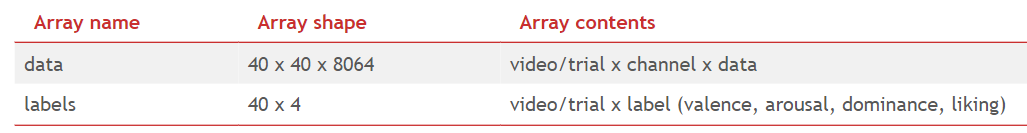

La siguiente tabla muestra el diseño de canales y el preprocesamiento realizado:

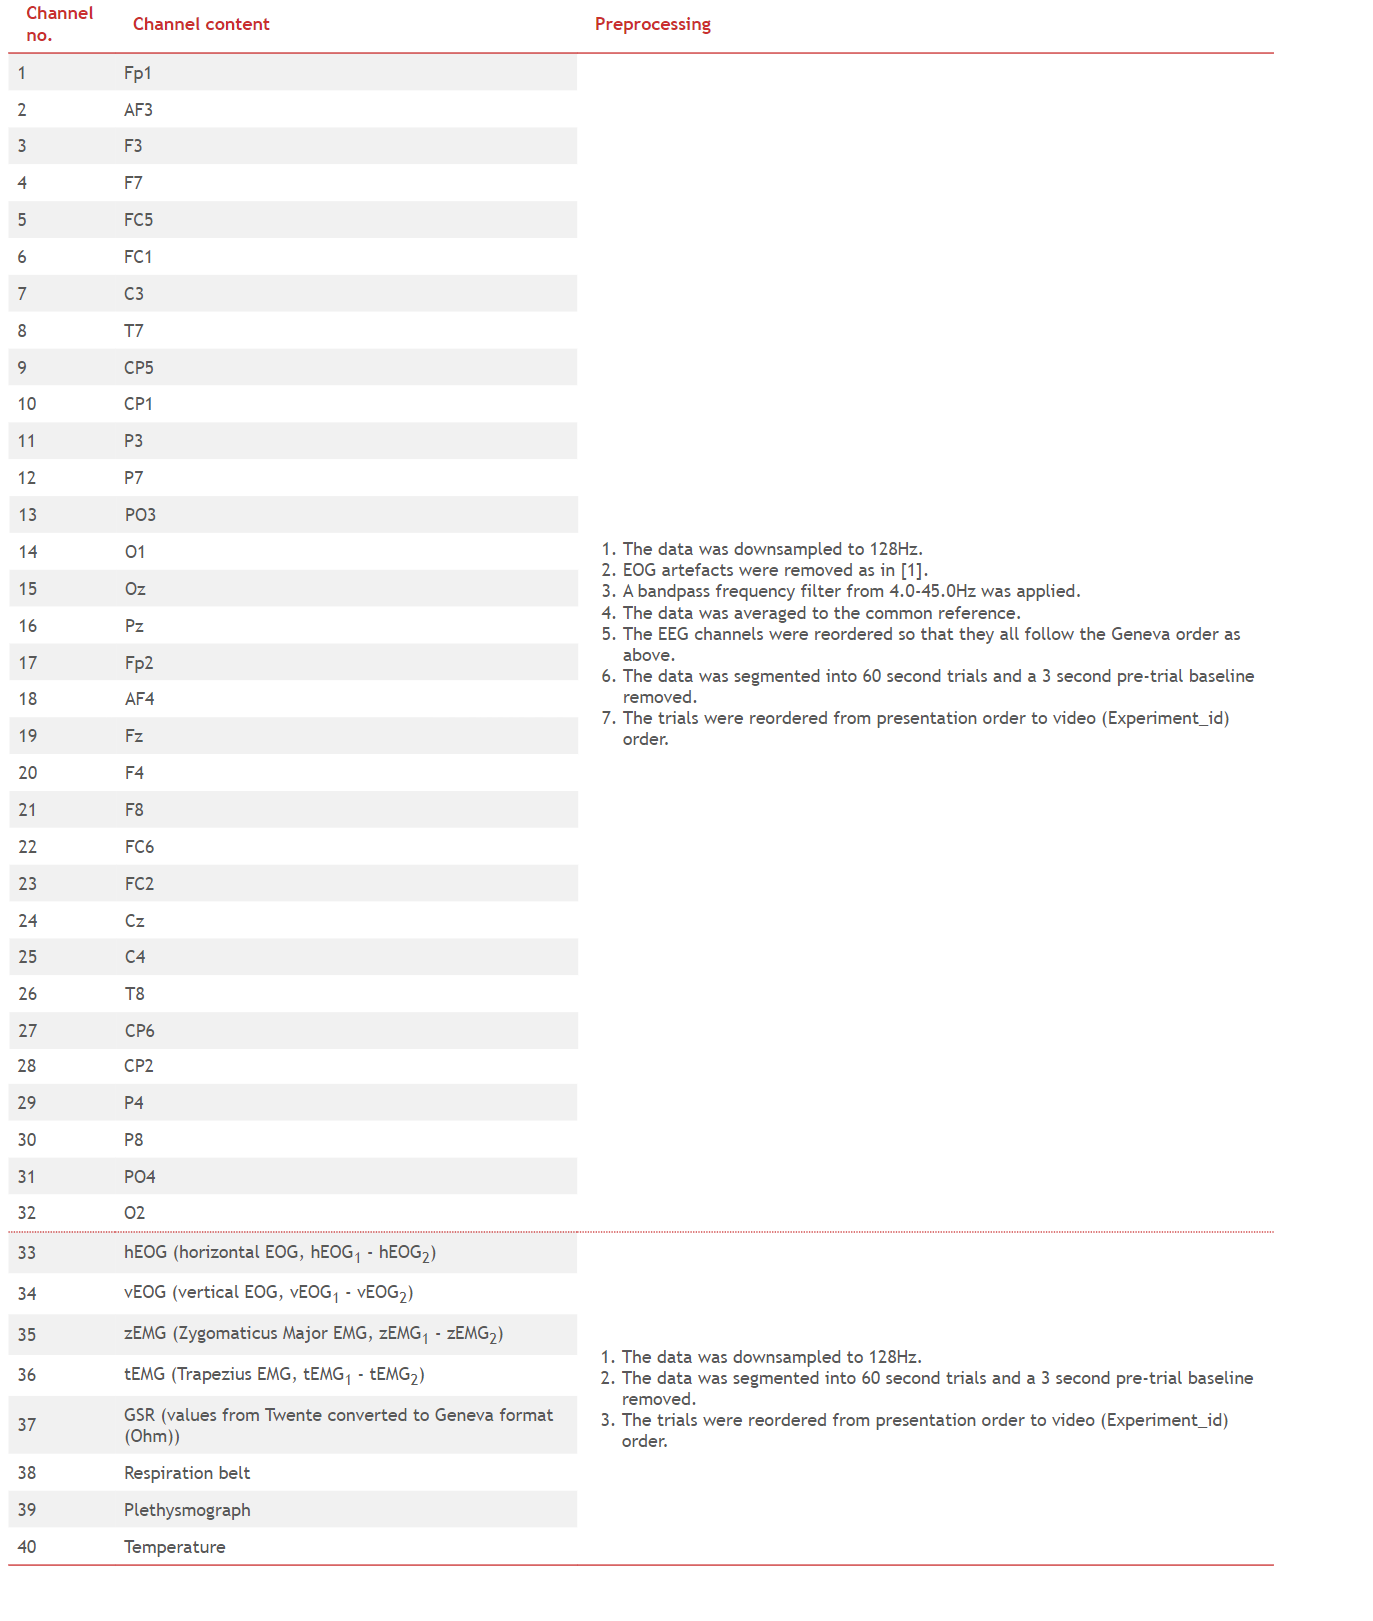

## Siglas señales fisiológicas

EEG: señales electroencefalográficas 
Generalmente son 32 canales 

EOG: electrooculograma (2 señales) movimientos verticales y horizontales

EMG: electromiogramas (2 señales) para los movimientos de los músculos (en la base de datos se capturó la señal del rostro).

Respiration belt:  banda que mide la frecuencia respiratoria

Temperatura: Mide la temperatura de la piel

Plethimograph:  Un pletismógrafo es un instrumento para medir cambios de volumen dentro de un órgano o de todo el cuerpo (generalmente como resultado de fluctuaciones en la cantidad de sangre o aire que contiene). Nos sirve como medida de el rítmo cardiaco (HR)

In [4]:
##Funciones 

#Funcion para sacar la media de las derivadas de una senal
def media_der(vect): 
  der=np.diff(vect)
  med_deri=np.mean(der)
  return med_deri

#Funcion filtro  pasabaja
def filtro_pasabaja(GSR,fcorte):
  b, a = scipy.signal.butter(2,fcorte/(128*0.5), btype="lowpass", analog=False)
  buffer1 = scipy.signal.lfilter(b, a, GSR)
  return buffer1

#Funcion filtro  pasaalta
def filtro_pasaalta(GSR,fcorte):
  b, a = scipy.signal.butter(2,fcorte/(128*0.5), btype="highpass", analog=False)
  buffer1 = scipy.signal.lfilter(b, a, GSR)
  return buffer1  

#Funcion filtro  pasabanda
def filtro_pasabanda(data,lowcut, highcut, fs, order=2):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = scipy.signal.butter(order, [low, high], btype='band',analog=False)
  y = scipy.signal.filtfilt(b, a, data)
  return  y

#Funcion que cuenta la muestras negativas vs todas las muestras en una senal
def negativo_vs_all(vector):
  vect=np.diff(vector)
  negativo=0
  for i in vect:
     if i < 0:
       negativo=negativo+1
  vs=negativo/len(vector)
  return vs

#Funcion Para sacar la energia de una senal
def energia_ojos(vector): 
  y=np.power(vector,2)
  y=np.sum(y)
  return (y)


#def Diezpicos(GSR):
#  temp=filtro_pasabaja(GSR,2.4)
#  temp=espectro_potencia(temp)
#  temp=picos(temp)
#  return temp

#Funcion para sacar el espectro de potencia de una senal
def espectro_potencia(GSR):
  f, Pxx_den = scipy.signal.welch(GSR, 128,nperseg=64)
  power=np.sum(Pxx_den)
  return power

#Funcion que cuenta los picos que tiene una senal (con umbral vertical)
def picos(señal):
  peaks, _ = find_peaks(señal,prominence=np.mean(señal))
  np.diff(peaks)
  return peaks 

#Funcion que cuenta los picos que tiene una senal (saca un pico cada cierta distancia)
def picosHR(señal):  
  peaks, _ = scipy.signal.find_peaks(señal,distance=50)
  np.diff(peaks)
  return len(peaks)

#Funcion desviacion estandar
def desviacion(señal):
  dev=np.std(señal)
  return dev

#Funcion para sacar la media de la senal
def media(señal):
  med=np.mean(señal)
  return med

#Funcion Varianza
def varianza(señal):
  var=np.var(señal)
  return var

#Funcion que saca la diferencia en logaritmos de 2 senales filtrabas anteriormente
def dif_log(señal):
  temp1=filtro_pasabanda(señal,0.05,0.25,128,order=2)
  temp2=filtro_pasabanda(señal,0.25,5,128,order=2)
  temp1=energia_ojos(temp1)
  temp2=energia_ojos(temp2)
  temp=np.log10(temp1)-np.log10(temp2)
  return temp

#Funcion que saca potencia de una senal que anteriormente fue filtrada por un pasabanda en la frecuencia delta
def pot_electrodos_delta(señal):
   temp=filtro_pasabanda(señal,0.5, 4, 128, order=2)
   f, Pxx= scipy.signal.welch(temp, 128,nperseg=64)
   power=np.sum(Pxx)
   return power

#Funcion que saca potencia de una senal que anteriormente fue filtrada por un pasabanda en la frecuencia teta
def pot_electrodos_teta(señal):
   temp=filtro_pasabanda(señal,4, 7, 128, order=2)
   f, Pxx= scipy.signal.welch(temp, 128,nperseg=64)
   power=np.sum(Pxx)
   return power

#Funcion que saca potencia de una senal que anteriormente fue filtrada por un pasabanda en la frecuencia alpha
def pot_electrodos_alpha(señal):
   temp=filtro_pasabanda(señal,7, 12, 128, order=2)
   f, Pxx= scipy.signal.welch(temp, 128,nperseg=64)
   power=np.sum(Pxx)
   return power

#Funcion que saca potencia de una senal que anteriormente fue filtrada por un pasabanda en la frecuencia beta
def pot_electrodos_beta(señal):
   temp=filtro_pasabanda(señal,13, 30, 128, order=2)
   f, Pxx= scipy.signal.welch(señal, 128,nperseg=64)
   power=np.sum(Pxx)
   return power

#Funcion que saca potencia de una senal que anteriormente se le resto otra senal (filtrado en delta)
def asymetric_delta(izq,dere):
  asy=izq-dere
  asy=pot_electrodos_delta(asy)
  return asy

#Funcion que saca potencia de una senal que anteriormente se le resto otra senal (filtrado en teta)
def asymetric_teta(izq,dere):
  asy=izq-dere
  asy=pot_electrodos_teta(asy)
  return asy

#Funcion que saca potencia de una senal que anteriormente se le resto otra senal (filtrado en alpha)
def asymetric_alpha(izq,dere):
  asy=izq-dere
  asy=pot_electrodos_alpha(asy)
  return asy

#Funcion que saca potencia de una senal que anteriormente se le resto otra senal (filtrado en beta)
def asymetric_beta(izq,dere):
  asy=izq-dere
  asy=pot_electrodos_beta(asy)
  return asy

In [34]:
#X es el vector con los videos y todos los canales 40 40 6528 
#video es el numero del video que va extraer 

#Funcion que saca las caracteristicas de GSR
def GSR(X2):
  chanel=X2[36]
  a=negativo_vs_all(chanel) #negativo derivado vs todas las muestras
  b=media_der(chanel)#media derivada
  c=media(chanel)#media de la señal
  return np.hstack([a,b,c])

#Funcion que saca las caracteristicas de Blood volume pressure
def Blood(X2):
  chanel=X2[38]
  a=picosHR(chanel) #frecuencia cardiaca en el tiempo del video 
  b=desviacion(chanel) #desviacion
  c=media(chanel) #media
  return np.hstack([a,b,c])

#Funcion que saca las caracteristicas de Respiration
def Respiration(X2):
  chanel=X2[37]
  a=dif_log(chanel) #diferencia de logaritmos 
  b=media_der(chanel) #media de las derivadas
  c=desviacion(chanel) #desviacion
  return np.hstack([a,b,c])

#Funcion que saca las caracteristicas de EOG y EMG
def EOG_EMG(X2):
  z=np.array([])
  for i in range(32,36):
    chanel=X2[i]
    a=energia_ojos(chanel)#Energia de la señal
    b=media(chanel)#media de la señal
    c=varianza(chanel)#varianza de la señal
    z=np.hstack([z,a,b,c])
  return z

#Funcion que saca las caracteristicas de temperatura de la piel
def Skin_temperature(X2):
  chanel=X2[39]
  a=media(chanel)#media de la señal
  b=media_der(chanel)#media de la señal
  c=filtro_pasabanda(chanel,0.1,0.2,128)
  c=espectro_potencia(c)
  return np.hstack([a,b,c])

#Funcion que saca las caracteristicas de EEG
def EEG(X2):
  abtg=[]
  for i in range(32):
    tempd=pot_electrodos_delta(X2[i])
    tempt=pot_electrodos_teta(X2[i])
    tempa=pot_electrodos_alpha(X2[i])
    tempb=pot_electrodos_beta(X2[i])
    abtg.append(tempd)
    abtg.append(tempt)
    abtg.append(tempa)
    abtg.append(tempb)
  X3=np.delete(X2,(14,15,18,23),0)
  for i in range(14):
    tempd2=asymetric_delta(X3[i],X3[i+14])
    tempt2=asymetric_teta(X3[i],X3[i+14])
    tempa2=asymetric_alpha(X3[i],X3[i+14])
    tempb2=asymetric_beta(X3[i],X3[i+14])
    abtg.append(tempd2)
    abtg.append(tempt2)
    abtg.append(tempa2)
    abtg.append(tempb2)
  return abtg

#Funcion que saca las caracteristicas de un video
def extraccion_caracteristicas_video(X,video): 
    X2= X[video-1,:]   
    return np.hstack([GSR(X2),Blood(X2),Skin_temperature(X2),EOG_EMG(X2),Respiration(X2),EEG(X2)])

#Funcion Sujeto
def extraccion_sujeto(X):
  M=[]
  for i in range (40):
    temp= extraccion_caracteristicas_video(X,i+1)
    M.append(temp)
  return M  

#Creamos la matriz de caracteristicas  
M=extraccion_sujeto(X)
M=np.array(M)

(40, 208)


## Etiquetas emocionales

Cada una de las realizaciones induce una emoción en los sujetos. Por lo tanto cada realización (de las 40) tiene sus correspondientes etiquetas de la forma:

Los modelos dimensionales sugieren que la emoción se entiende mejor cuando ocurre dentro de un espacio dimensional, más comúnmente un espacio bidimensional que abarca la valencia y la excitación. La valencia emocional describe el grado en que una emoción es positiva o negativa, mientras que la excitación se refiere a su intensidad, es decir, la fuerza del estado emocional asociado.


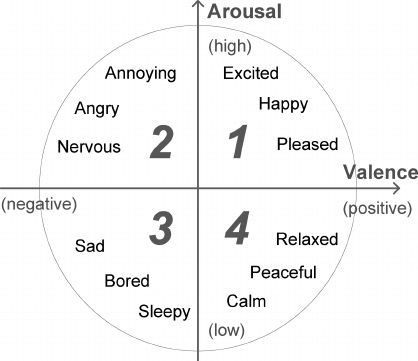

Las etiquetas están en el campo label:

labels	es una matriz de $40 \times 4$ en la cual se organiza de la forma	$video/trial \times label $ (valence, arousal, dominance, liking)

Valence	The valence rating (float between 1 and 9).
Arousal	The arousal rating (float between 1 and 9).
Dominance	The dominance rating (float between 1 and 9).
Liking	The liking rating (float between 1 and 9).


In [42]:
labels = db['labels']
Valence = labels[:,0]
Arousal = labels[:,1]

negA = np.logical_and(Arousal>=1,Arousal<=3)
negV = np.logical_and(Valence>=1,Valence<=3)
neutralA = np.logical_and(Arousal>3,Arousal<7)
neutralV = np.logical_and(Valence>3,Valence<7)
posA = Arousal>=7
posV = Valence>=7
Etiquetas = np.zeros((40,1))
# Emocion Negativa negA y negV
Etiquetas[np.where(np.logical_and(negA,negV))] = 1.
# Emocion Neutral neutralA y neutralV
Etiquetas[np.where(np.logical_and(neutralA,neutralA))] = 2.
# Emocion Positiva posA y posV
Etiquetas[np.where(np.logical_and(posA,posV))] = 3.
# Emocion Stress posA y negV
Etiquetas[np.where(np.logical_and(posA,negV))] = 4.
# Emocion Calm negA y posV
Etiquetas[np.where(np.logical_and(negA,posV))] = 5.
# Emocion Tristeza neutralA y negV
Etiquetas[np.where(np.logical_and(neutralA,negV))] = 6.
# Emocion Satisfecho (Pleasant) neutralA y posV
Etiquetas[np.where(np.logical_and(neutralA,posV))] = 7.
# Emocion Tranquilidad negA y neutralV
Etiquetas[np.where(np.logical_and(negA,neutralV))] = 8.
# Emocion Sorpresa posA y neutralV
Etiquetas[np.where(np.logical_and(posA,neutralV))] = 9.

M=np.append(M,Etiquetas,axis=1)


In [41]:
import pandas as pd

datos={"GSR_negaderivsall":M[:,0], "GSR_mediaderivada":M[:,1],"GSR_media":M[:,2],"Blood_picosHR":M[:,3],"Blood_desviacion":M[:,4],"Blood_media":M[:,5],
       "hEOG_energia":M[:,6],"hEOG_media":M[:,7],"hEOG_varianza":M[:,8],"vEOG_energia":M[:,9],"vEOG_media":M[:,10],"vEOG_varianza":M[:,11],
       "zEMG_energia":M[:,12],"zEMG_media":M[:,13],"zEMG_varianza":M[:,14],"tEMG_energia":M[:,15],"tEMG_media":M[:,16],"tEMG_varianza":M[:,17],
       "SKINT_media":M[:,18],"SKINT_mediaderi":M[:,19],"SKINT_Espec":M[:,20],"RESPIRATION_diflog":M[:,21],"RESPIRATION_media":M[:,22],"RESPIRATION_desvia":M[:,23],
       "EEGFP1_pot_electrodos_delta":M[:,24],"EEGFP1_pot_electrodos_teta":M[:,25],"EEGFP1_pot_electrodos_alpha":M[:,26],"EEGFP1_pot_electrodos_beta":M[:,27],
       "EEGAF3_pot_electrodos_delta":M[:,28],"EEGAF3_pot_electrodos_teta":M[:,29],"EEGAF3_pot_electrodos_alpha":M[:,30],"EEGAF3_pot_electrodos_beta":M[:,31],
       "EEGF3_pot_electrodos_delta":M[:,32],"EEGF3_pot_electrodos_teta":M[:,33],"EEGF3_pot_electrodos_alpha":M[:,34],"EEGF3_pot_electrodos_beta":M[:,35],
       "EEGF7_pot_electrodos_delta":M[:,36],"EEGF7_pot_electrodos_teta":M[:,37],"EEGF7_pot_electrodos_alpha":M[:,38],"EEGF7_pot_electrodos_beta":M[:,39],
       "EEGFC5_pot_electrodos_delta":M[:,40],"EEGFC5_pot_electrodos_teta":M[:,41],"EEGFC5_pot_electrodos_alpha":M[:,42],"EEGFC5_pot_electrodos_beta":M[:,43],
       "EEGFC1_pot_electrodos_delta":M[:,44],"EEGFC1_pot_electrodos_teta":M[:,45],"EEGFC1_pot_electrodos_alpha":M[:,46],"EEGFC1_pot_electrodos_beta":M[:,47],
       "EEGC3_pot_electrodos_delta":M[:,48],"EEGC3_pot_electrodos_teta":M[:,49],"EEGC3_pot_electrodos_alpha":M[:,50],"EEGC3_pot_electrodos_beta":M[:,51],
       "EEGT7_pot_electrodos_delta":M[:,52],"EEGT7_pot_electrodos_teta":M[:,53],"EEGT7_pot_electrodos_alpha":M[:,54],"EEGT7_pot_electrodos_beta":M[:,55],
       "EEGCP5_pot_electrodos_delta":M[:,56],"EEGCP5_pot_electrodos_teta":M[:,57],"EEGCP5_pot_electrodos_alpha":M[:,58],"EEGCP5_pot_electrodos_beta":M[:,59],
       "EEGCP1_pot_electrodos_delta":M[:,60],"EEGCP1_pot_electrodos_teta":M[:,61],"EEGCP1_pot_electrodos_alpha":M[:,62],"EEGCP1_pot_electrodos_beta":M[:,63],
       "EEGP3_pot_electrodos_delta":M[:,64],"EEGP3_pot_electrodos_teta":M[:,65],"EEGP3_pot_electrodos_alpha":M[:,66],"EEGP3_pot_electrodos_beta":M[:,67],
       "EEGP7_pot_electrodos_delta":M[:,68],"EEGP7_pot_electrodos_teta":M[:,69],"EEGP7_pot_electrodos_alpha":M[:,70],"EEGP7_pot_electrodos_beta":M[:,71],
       "EEGPO3_pot_electrodos_delta":M[:,72],"EEGPO3_pot_electrodos_teta":M[:,73],"EEGPO3_pot_electrodos_alpha":M[:,74],"EEGPO3_pot_electrodos_beta":M[:,75],
       "EEGO1_pot_electrodos_delta":M[:,76],"EEGO1_pot_electrodos_teta":M[:,77],"EEGO1_pot_electrodos_alpha":M[:,78],"EEGO1_pot_electrodos_beta":M[:,79],
       "EEGOZ_pot_electrodos_delta":M[:,80],"EEGOZ_pot_electrodos_teta":M[:,81],"EEGOZ_pot_electrodos_alpha":M[:,82],"EEGOZ_pot_electrodos_beta":M[:,83],
       "EEGPZ_pot_electrodos_delta":M[:,84],"EEGPZ_pot_electrodos_teta":M[:,85],"EEGPZ_pot_electrodos_alpha":M[:,86],"EEGPZ_pot_electrodos_beta":M[:,87],
       "EEGFP2_pot_electrodos_delta":M[:,88],"EEGFP2_pot_electrodos_teta":M[:,89],"EEGFP2_pot_electrodos_alpha":M[:,90],"EEGFP2_pot_electrodos_beta":M[:,91],
       "EEGAF4_pot_electrodos_delta":M[:,92],"EEGAF4_pot_electrodos_teta":M[:,93],"EEGAF4_pot_electrodos_alpha":M[:,94],"EEGAF4_pot_electrodos_beta":M[:,95],
       "EEGFZ_pot_electrodos_delta":M[:,96],"EEGFZ_pot_electrodos_teta":M[:,97],"EEGFZ_pot_electrodos_alpha":M[:,98],"EEGFZ_pot_electrodos_beta":M[:,99],
       "EEGF4_pot_electrodos_delta":M[:,100],"EEGF4_pot_electrodos_teta":M[:,101],"EEGF4_pot_electrodos_alpha":M[:,102],"EEGF4_pot_electrodos_beta":M[:,103],
       "EEGF8_pot_electrodos_delta":M[:,104],"EEGF8_pot_electrodos_teta":M[:,105],"EEGF8_pot_electrodos_alpha":M[:,106],"EEGF8_pot_electrodos_beta":M[:,107],
       "EEGFC6_pot_electrodos_delta":M[:,108],"EEGFC6_pot_electrodos_teta":M[:,109],"EEGFC6_pot_electrodos_alpha":M[:,110],"EEGFC6_pot_electrodos_beta":M[:,111],
       "EEGFC2_pot_electrodos_delta":M[:,112],"EEGFC2_pot_electrodos_teta":M[:,113],"EEGFC2_pot_electrodos_alpha":M[:,114],"EEGFC2_pot_electrodos_beta":M[:,115],
       "EEGCZ_pot_electrodos_delta":M[:,116],"EEGCZ_pot_electrodos_teta":M[:,117],"EEGCZ_pot_electrodos_alpha":M[:,118],"EEGCZ_pot_electrodos_beta":M[:,119],
       "EEGC4_pot_electrodos_delta":M[:,120],"EEGC4_pot_electrodos_teta":M[:,121],"EEGC4_pot_electrodos_alpha":M[:,122],"EEGC4_pot_electrodos_beta":M[:,123],
       "EEGT8_pot_electrodos_delta":M[:,124],"EEGT8_pot_electrodos_teta":M[:,125],"EEGT8_pot_electrodos_alpha":M[:,126],"EEGT8_pot_electrodos_beta":M[:,127],
       "EEGCP6_pot_electrodos_delta":M[:,128],"EEGCP6_pot_electrodos_teta":M[:,129],"EEGCP6_pot_electrodos_alpha":M[:,130],"EEGCP6_pot_electrodos_beta":M[:,131],
       "EEGCP2_pot_electrodos_delta":M[:,132],"EEGCP2_pot_electrodos_teta":M[:,133],"EEGCP2_pot_electrodos_alpha":M[:,134],"EEGCP2_pot_electrodos_beta":M[:,135],
       "EEGP4_pot_electrodos_delta":M[:,136],"EEGP4_pot_electrodos_teta":M[:,137],"EEGP4_pot_electrodos_alpha":M[:,138],"EEGP4_pot_electrodos_beta":M[:,139],
       "EEGP8_pot_electrodos_delta":M[:,140],"EEGP8_pot_electrodos_teta":M[:,141],"EEGP8_pot_electrodos_alpha":M[:,142],"EEGP8_pot_electrodos_beta":M[:,143],
       "EEGPO4_pot_electrodos_delta":M[:,144],"EEGPO4_pot_electrodos_teta":M[:,145],"EEGPO4_pot_electrodos_alpha":M[:,146],"EEGPO4_pot_electrodos_beta":M[:,147],
       "EEGO2_pot_electrodos_delta":M[:,148],"EEGO2_pot_electrodos_teta":M[:,149],"EEGO2_pot_electrodos_alpha":M[:,150],"EEGO2_pot_electrodos_beta":M[:,151],
       "EEGFP1FP2_pot_asym_delta":M[:,152],"EEGFP1FP2_pot_asym_teta":M[:,153],"EEGFP1FP2_pot_asym_alpha":M[:,154],"EEGFP1FP2_pot_asym_beta":M[:,155],
       "EEGAF3AF4_pot_asym_delta":M[:,156],"EEGAF3AF4_pot_asym_teta":M[:,157],"EEGAF3AF4_pot_asym_alpha":M[:,158],"EEGAF3AF4_pot_asym_beta":M[:,159],
       "EEGF3F4_pot_asym_delta":M[:,160],"EEGF3F4_pot_asym_teta":M[:,161],"EEGF3F4_pot_asym_alpha":M[:,162],"EEGF3F4_pot_asym_beta":M[:,163],
       "EEGF7F8_pot_asym_delta":M[:,164],"EEGF7F8_pot_asym_teta":M[:,165],"EEGF7F8_pot_asym_alpha":M[:,166],"EEGF7F8_pot_asym_beta":M[:,167],
       "EEGFC5FC6_pot_asym_delta":M[:,168],"EEGFC5FC6_pot_asym_teta":M[:,169],"EEGFC5FC6_pot_asym_alpha":M[:,170],"EEGFC5FC6_pot_asym_beta":M[:,171],
       "EEGFC1FC2_pot_asym_delta":M[:,172],"EEGFC1FC2_pot_asym_teta":M[:,173],"EEGFC1FC2_pot_asym_alpha":M[:,174],"EEGFC1FC2_pot_asym_beta":M[:,175],
       "EEGC3C4_pot_asym_delta":M[:,176],"EEGC3C4_pot_asym_teta":M[:,177],"EEGC3C4_pot_asym_alpha":M[:,178],"EEGC3C4_pot_asym_beta":M[:,179],
       "EEGT7T8_pot_asym_delta":M[:,180],"EEGT7T8_pot_asym_teta":M[:,181],"EEGT7T8_pot_asym_alpha":M[:,182],"EEGT7T8_pot_asym_beta":M[:,183],
       "EEGCP5CP6_pot_asym_delta":M[:,184],"EEGCP5CP6_pot_asym_teta":M[:,185],"EEGCP5CP6_pot_asym_alpha":M[:,186],"EEGCP5CP6_pot_asym_beta":M[:,187],
       "EEGCP1CP2_pot_asym_delta":M[:,188],"EEGCP1CP2_pot_asym_teta":M[:,189],"EEGCP1CP2_pot_asym_alpha":M[:,190],"EEGCP1CP2_pot_asym_beta":M[:,191],
       "EEGP3P4_pot_asym_delta":M[:,192],"EEGP3P4_pot_asym_teta":M[:,193],"EEGP3P4_pot_asym_alpha":M[:,194],"EEGP3P4_pot_asym_beta":M[:,195],
       "EEGP7P8_pot_asym_delta":M[:,196],"EEGP7P8_pot_asym_teta":M[:,197],"EEGP7P8_pot_asym_alpha":M[:,198],"EEGP7P8_pot_asym_beta":M[:,199],
       "EEGPO3PO4_pot_asym_delta":M[:,200],"EEGPO3PO4_pot_asym_teta":M[:,201],"EEGPO3PO4_pot_asym_alpha":M[:,202],"EEGPO3PO4_pot_asym_beta":M[:,203],
       "EEGO1O2_pot_asym_delta":M[:,204],"EEGO1O2_pot_asym_teta":M[:,205],"EEGO1O2_pot_asym_alpha":M[:,206],"EEGO1O2_pot_asym_beta":M[:,207],
       "Etiquetas":M[:,208]}


df = pd.DataFrame(datos)

print(df)

    GSR_negaderivsall  GSR_mediaderivada  ...  EEGO1O2_pot_asym_beta  Etiquetas
0            0.157322          -0.262750  ...              32.749521        2.0
1            0.138021           0.339940  ...              53.120937        3.0
2            0.095282           1.371729  ...              39.959963        2.0
3            0.061887           1.885378  ...              15.552665        2.0
4            0.099265           1.466468  ...              31.880877        3.0
5            0.127911           0.373426  ...              41.406364        2.0
6            0.064951           1.017992  ...              23.274781        7.0
7            0.163143          -0.374708  ...              42.147066        2.0
8            0.128676           0.059366  ...              33.994066        2.0
9            0.136183           0.237330  ...              43.009397        9.0
10           0.097273           1.053573  ...              47.935835        2.0
11           0.142157          -0.124669

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


    GSR_negaderivsall  GSR_mediaderivada  ...  Blood_desviacion  Etiquetas
0            0.157322          -0.262750  ...      11183.749355        2.0
1            0.138021           0.339940  ...       3224.369381        3.0
2            0.095282           1.371729  ...       4166.824217        2.0
3            0.061887           1.885378  ...       6518.678526        2.0
4            0.099265           1.466468  ...       4239.943926        3.0
5            0.127911           0.373426  ...      10105.726432        2.0
6            0.064951           1.017992  ...       5706.719051        7.0
7            0.163143          -0.374708  ...       3528.739279        2.0
8            0.128676           0.059366  ...       2802.911570        2.0
9            0.136183           0.237330  ...       5329.332832        9.0
10           0.097273           1.053573  ...      10956.183852        2.0
11           0.142157          -0.124669  ...      11588.125792        2.0
12           0.125153    

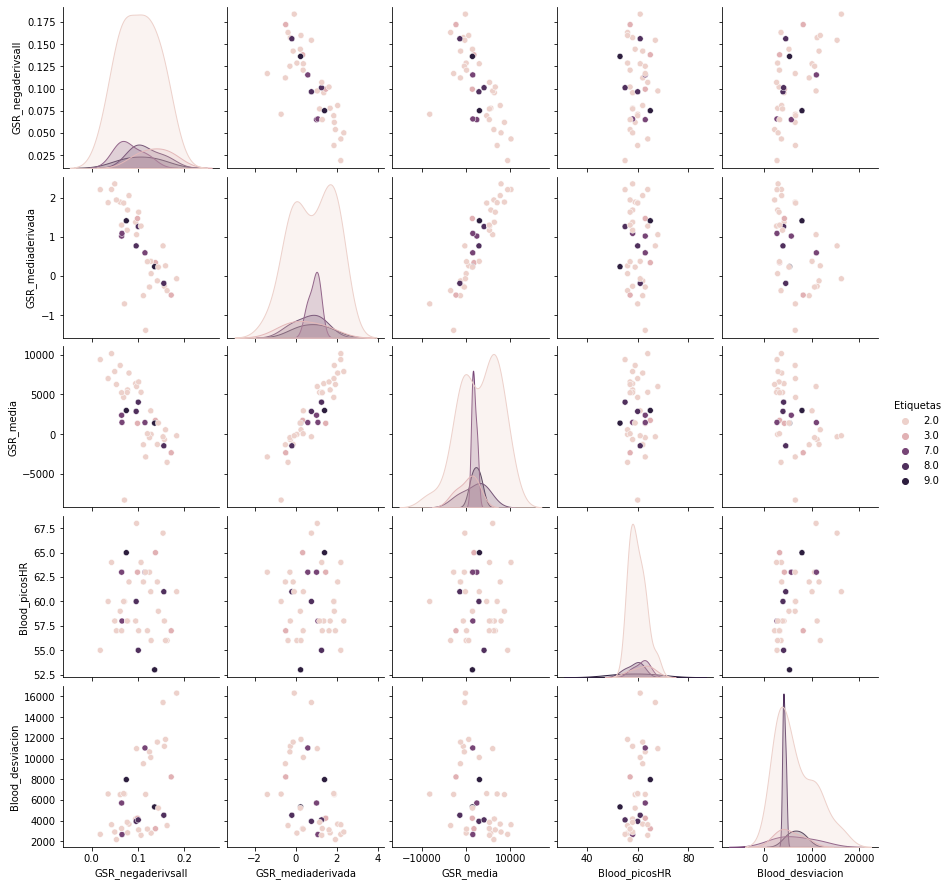

In [79]:
import seaborn as sns
nueva=[]
nueva=df.iloc [:,:5]
nueva['Etiquetas'] = df.iloc[:,208]
print(nueva)
#iris = sns.load_dataset("iris")
#iris.head()
sns.pairplot(nueva,hue='Etiquetas');

